In [1]:
!nvidia-smi

Wed Jul 27 12:54:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   58C    P0   238W / 300W |  21027MiB / 32505MiB |     83%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from matplotlib import colors

from skimage.transform import resize

In [4]:
hashs =[("2022-07-02_08-00-31", "2022-07-03_13-41-32"),
        ("2022-07-02_08-00-57", "2022-07-03_13-37-29"),
        ("2022-07-02_09-38-52", "2022-07-03_13-33-23"),
        ("2022-07-02_09-40-42", "2022-07-03_13-29-10"),
        ("2022-07-02_11-17-38", "2022-07-03_13-25-05"),
        ("2022-07-02_11-20-21", "2022-07-03_13-21-00"),
        ("2022-07-02_17-15-14", "2022-07-03_13-16-54"),
        ("2022-07-02_17-15-34", "2022-07-03_13-12-44"),
        ("2022-07-02_18-53-46", "2022-07-03_13-08-35"),
        ("2022-07-02_18-54-27", "2022-07-03_13-04-32")]

In [5]:
gpus = ['3']
server = 'dgx'
hash = hashs[0]

In [6]:
config = edict()
config.server = server
config.gpus = gpus
local_rank = 0

config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/ckpt.last.pth.tar')
finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/configs.json')
with open(finetune_config, 'rb') as fb:
    finetune_config = json.load(fb)

finetune_config_names = [
    # data_parser
    'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
    'image_size', 'small_kernel', 'random_state',
    'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
    # model_parser
    'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
    'arch', 'no_max_pool',
    # train
    'batch_size',
    # moco / supmoco
    'alphas',
    # others
    'task', 'projector_dim'
]

for name in finetune_config_names:
    if name in finetune_config.keys():
        setattr(config, name, finetune_config[name])

In [7]:
set_gpu(config)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
else:
    raise NotImplementedError

if config.small_kernel:
    backbone._fix_first_conv()

if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
classifier.load_weights_from_checkpoint(path=config.finetune_file, key='classifier')

# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  mean_std=mean_std,
                                                  min_max=min_max,
                                                  crop=config.crop,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur=config.blur,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

In [10]:
total_set = {'mri': datasets['train']['mri'] + datasets['u_train']['mri'],
             'pet': datasets['train']['pet'] + datasets['u_train']['pet'],
             'y': np.concatenate([datasets['train']['y'], datasets['u_train']['y']])}
total_set = Brain(dataset=total_set, data_type=config.data_type, transform=test_transform)
total_loader = DataLoader(dataset=total_set, batch_size=16, drop_last=False)

In [11]:
@torch.no_grad()
def extract_features(data_loader, encoder: nn.Module, projector: nn.Module, device: int):
    
    encoder.to(device)
    encoder.eval()
    
    
    
    Z = []
    y = []
    for i, batch in enumerate(data_loader):
        x = batch['x'].to(device)
        z = encoder(x)        
        Z += [z]
        y += [batch['y'].to(device)]
        
    encoder.to('cpu')
    
    Z = torch.cat(Z, dim=0)
    y = torch.cat(y, dim=0)
    
    return Z, y

In [13]:
Z, Y = extract_features(total_loader, backbone, 0)

In [14]:
Z = nn.AdaptiveAvgPool3d(1)(Z)

In [15]:
Z = np.squeeze(Z)

In [16]:
Z.shape

torch.Size([984, 2048])

In [17]:
import umap.umap_ as umap

In [24]:
Z = Z.detach().cpu().numpy()
Y = Y.detach().cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [31]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)

In [32]:
embedding = reducer.fit_transform(Z)

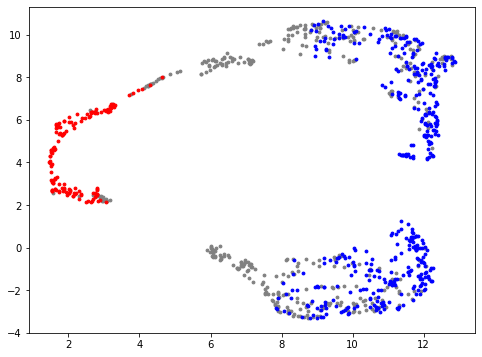

In [37]:
classes = [-1, 0, 1]
colors = ['grey', 'blue', 'red']
plt.figure(figsize=(8, 6))
for c, color in zip(classes, colors):
    plt.scatter(embedding[Y==c, 0], embedding[Y==c, 1], s=8, color=colors[c+1])
plt.show()

In [72]:
Y

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [60]:
plt.figure(figsize=(8, 8))
plt.scatter(embedding[Y.cpu().numpy()==0, 0], embedding[Y.cpu().numpy()==0, 1], c=Y.cpu().numpy()[Y==0], s=8, color='grey')
plt.scatter(embedding[Y.cpu().numpy()==1, 0], embedding[Y.cpu().numpy()==1, 1], c=Y.cpu().numpy()[Y==1], s=8, color='red')
plt.title('Testing', fontsize=24)
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 576x576 with 0 Axes>

In [ ]:
from utils.metrics import classification_result

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, local_rank=0, adjusted=False):
    """Evaluation defined for a single epoch."""

    steps = len(data_loader)
    model.backbone.eval()
    model.classifier.eval()
    y_true, y_pred = [], []
    for i, batch in enumerate(data_loader):
        x = batch['x'].float().to(local_rank)
        y = batch['y'].to(local_rank)
        logits = model(x)        
        y_true.append(y.long())
        y_pred.append(logits)

    # accuracy and macro f1 score
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0).to(torch.float32)

    clf_result = classification_result(y_true=y_true.cpu().numpy(),
                                       y_pred=y_pred.softmax(1).detach().cpu().numpy(),
                                       adjusted=adjusted)
    result = {}
    for k, v in clf_result.items():
        result[k] = v

    return result

In [ ]:
eval_result = evaluate(model=model, data_loader=test_loader, local_rank=0, adjusted=True)
print(eval_result)

In [ ]:
@torch.no_grad()
def sample_prediction(model, data_loader, local_rank=0, adjusted=False):
    """Evaluation defined for a single epoch."""

    steps = len(data_loader)
    model.backbone.eval()
    model.classifier.eval()
    y_true, y_pred = [], []
    idx = []
    for i, batch in enumerate(data_loader):
        x = batch['x'].float().to(local_rank)
        y = batch['y'].to(local_rank)
        
        logits = model(x)        
        y_true.append(y.long())
        y_pred.append(logits)
        idx.append(batch['idx'])

    # accuracy and macro f1 score
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0).to(torch.float32)
    idx = torch.cat(idx, dim=0)
    return y_true, y_pred, idx

In [ ]:
y_true, y_pred, idx = sample_prediction(model, test_loader)

In [ ]:
pmci_idx, smci_idx = [], []
for t, p, i in zip(y_true, y_pred.softmax(1), idx):
    if torch.argmax(p) == t:
        if t == 0:
            if p[t].item() > 0.95:
                smci_idx.append(i.item())
        if t == 1:
            if p[t].item() > 0.95:
                pmci_idx.append(i.item())

In [ ]:
def get_map(data, target_layer, model, local_rank):
    
    model.eval()
    
    gcam = GradCAMpp(model, target_layer)
    guided = GuidedBackpropGrad(model)
    
    # predict
    x = torch.as_tensor(data['x'][None].to(local_rank))        
    pred_logits = model(x)
    model.zero_grad()
    
    pred_label = pred_logits.argmax(dim=1).item()
    pred_prob = torch.nn.functional.softmax(pred_logits, dim=1)[0, pred_label].item() * 100

    title = f"Pred: {pred_label} ({pred_prob:.2f}%) | True: {data['y']}"

    # image
    img = torch.moveaxis(x, 1, -1)

    # gradcam
    gcam_map = gcam(x=x, class_idx=pred_label)[0]
    model.zero_grad()

    # guided
    guided_map = guided(x)
    model.zero_grad()
    guided_map = torch.sum(guided_map ** 2, dim=1) ** 0.5
    
    # shape
    img = img.cpu().detach().numpy()
    img = np.squeeze(img)
    
    gcam_map = gcam_map.cpu().detach().numpy()
    gcam_map = np.squeeze(gcam_map)
    
    guided_map = guided_map.cpu().detach().numpy()
    guided_map = np.squeeze(guided_map)
    
    return img, gcam_map, guided_map, title

In [ ]:
_, orig_transform = make_transforms(image_size=145, intensity=None, mean_std=mean_std, min_max=min_max, crop=False, rotate=config.rotate,
                                    flip=config.flip, affine=config.affine, blur=config.blur, blur_std=config.blur_std, prob=config.prob)
orig_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=orig_transform)
pmci_orig_set = np.array(Subset(orig_set, pmci_idx))
smci_orig_set = np.array(Subset(orig_set, smci_idx))

In [ ]:
# pmci
pmci_set = np.array(Subset(test_set, pmci_idx))
smci_set = np.array(Subset(test_set, smci_idx))

In [ ]:
i = 0
vmin = 0.4
loc1 = 80
loc2 = 60
loc3 = 100

In [ ]:
i = 3
vmin = 0.3
loc1 = 80
loc2 = 60
loc3 = 100

In [ ]:
i = 5
vmin = 0.3
loc1 = 80
loc2 = 60
loc3 = 100

In [ ]:
data = pmci_set[i]
orig_data = pmci_orig_set[i]
org = orig_data['x']

In [ ]:
img, gcamp_map, guided_map, title = get_map(data, 'backbone.layer1', model, local_rank)
gcamp_map_t = np.abs(1 - gcamp_map)

In [ ]:
tr = resize(gcamp_map_t, [145, 145, 145])

In [ ]:
title

In [ ]:
tr_m = tr.copy()
bmask = org[0] <= 0
tr_m[bmask] = np.nan

m = tr_m < vmin
tr_m[m] = np.nan

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))
axs = axs.ravel()

axs[0].imshow(org[0, loc1, :, :], cmap='binary')
axs[1].imshow(tr_m[loc1, :, :], cmap='jet', alpha=0.2, vmin=vmin)
axs[2].imshow(org[0, loc1, :, :], cmap='binary')
axs[2].imshow(tr_m[loc1, :, :], cmap='jet', alpha=0.2, vmin=vmin)


axs[3].imshow(org[0, :, loc2, :], cmap='binary')
axs[4].imshow(tr_m[:, loc2, :], cmap='jet', alpha=0.2, vmin=vmin)
axs[5].imshow(org[0, :, loc2, :], cmap='binary')
axs[5].imshow(tr_m[:, loc2, :], cmap='jet', alpha=0.2, vmin=vmin)

axs[6].imshow(org[0, :, :, loc3], cmap='binary')
axs[7].imshow(tr_m[:, :, loc3], cmap='jet', alpha=0.2, vmin=vmin)
axs[8].imshow(org[0, :, :, loc3], cmap='binary')
axs[8].imshow(tr_m[:, :, loc3], cmap='jet', alpha=0.2, vmin=vmin)


plt.show()

In [ ]:
fig = plt.figure()
matshow3d(a, fig=fig, title="3D Volume", figsize=(20, 20))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.visualize import matshow3d
fig = plt.figure()
matshow3d(t, fig=fig, title="3D Volume", figsize=(20, 20), cmap='jet')
plt.show()